# **MOVIES REVIEWS CLASSIFICATION USING LMMs**

This notebook demonstrates the practical differences between encoder-only and decoder-only transformer architectures through a classification task. We'll explore:

**KEY CONCEPTS BEING COMPARED:**
1) **Encoder-only models (BERT)**: Designed for understanding tasks, fine-tuned for classification
2) **Decoder-only models (Phi-3)**: Originally for generation, adapted for classification using proper chat templates
3) **Fine-tuning vs Prompt Engineering**: Comparing supervised learning against instruction-following approaches

**WHY THIS COMPARISON MATTERS:**
- Shows when to use fine-tuning vs prompting
- Demonstrates architectural differences in practice
- Helps choose the right approach based on data availability and computational resources

## **Library Imports and Environment Setup**

**Purpose**: Import all necessary libraries and configure the environment for stable model training.

**Key Components:**
- **PyTorch & TensorFlow**: Deep learning frameworks
- **HuggingFace Transformers**: Pre-trained model library (BERT, Phi-3)
- **Datasets**: Efficient data handling
- **scikit-learn**: Evaluation metrics
- **Environment Variables**: Prevent common issues during training

In [ ]:
import torch
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForCausalLM, TrainingArguments, Trainer,
    BitsAndBytesConfig
)
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import softmax
from tqdm.auto import tqdm  # Fixed import
import time
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set environment variables for better stability
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging
os.environ["TRANSFORMERS_VERBOSITY"] = "error"  # Reduce transformer warnings

## **Data Import**

**Dataset**: IMDB movie review dataset for binary sentiment classification (positive/negative)

**Why IMDB**:
- Well-established benchmark for sentiment analysis
- Large dataset (50K reviews) but we use subset (5K train, 1K test) for fast training
- Binary classification makes it easy to compare model performance

**Data Processing Steps:**
1. Load IMDB data via Keras (comes as word indices, not text)
2. Convert indices back to readable text using word mappings
3. Create balanced subsets for efficient training
4. Convert to HuggingFace Dataset format for transformer compatibility

**Subset Rationale**: Full dataset would take hours to train - subset allows quick architectural comparison

In [ ]:
# Method 1: Load IMDB dataset using tensorflow_datasets (recommended)
print("Loading IMDB dataset using TensorFlow Datasets...")

from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Load data - we'll get word indices first, then convert back to text
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=100000)

# Get the word index
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#convert from idx to words
def sequence_to_text(sequence):
    words = []
    for i in sequence:
        if i >= 4:  # Only process actual vocabulary words
            words.append(reverse_word_index.get(i - 3, '[UNK]'))
    return ' '.join(words)

# Convert back to text
train_texts = [sequence_to_text(seq) for seq in x_train]
train_labels = list(y_train)
test_texts = [sequence_to_text(seq) for seq in x_test]
test_labels = list(y_test)

print("✅ Successfully loaded IMDB dataset using Keras!")

# Create smaller subsets for faster training in Colab
print("Creating training subset...")
# Shuffle and select subset
import random
combined_train = list(zip(train_texts, train_labels))
random.shuffle(combined_train)
train_subset = combined_train[:5000]  # 5K for training
train_texts_subset, train_labels_subset = zip(*train_subset)

combined_test = list(zip(test_texts, test_labels))
random.shuffle(combined_test)
test_subset = combined_test[:1000]  # 1K for testing
test_texts_subset, test_labels_subset = zip(*test_subset)

# Convert back to HuggingFace Dataset format for compatibility with transformers
train_dataset = Dataset.from_dict({
    'text': list(train_texts_subset),
    'label': list(train_labels_subset)
})

test_dataset = Dataset.from_dict({
    'text': list(test_texts_subset),
    'label': list(test_labels_subset)
})

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Display sample data
print("\nSample reviews:")
for i in range(2):
    text_preview = train_dataset[i]['text'][:200] + "..." if len(train_dataset[i]['text']) > 200 else train_dataset[i]['text']
    print(f"Text: {text_preview}")
    print(f"Label: {train_dataset[i]['label']} ({'Positive' if train_dataset[i]['label'] == 1 else 'Negative'})")
    print("-" * 50)

# Show label distribution
train_labels_array = np.array(train_dataset['label'])
print(f"\nLabel distribution in training set:")
print(f"Negative (0): {np.sum(train_labels_array == 0)} samples")
print(f"Positive (1): {np.sum(train_labels_array == 1)} samples")

Loading IMDB dataset using TensorFlow Datasets...
✅ Successfully loaded IMDB dataset using Keras!
Creating training subset...
Training samples: 5000
Test samples: 1000

Sample reviews:
Text: the bat people is a really bad film that deserved the mst3k treatment just as well like that other film the creeping terror br br in it we are in some sort of mountainous terrain full of bats we see m...
Label: 0 (Negative)
--------------------------------------------------
Text: this movie is fun to watch if you liked dave with kevin klein you will get a kick out of this think dave gone south american as dreyfus plays jack noah an actor between jobs who is hand selected by th...
Label: 1 (Positive)
--------------------------------------------------

Label distribution in training set:
Negative (0): 2511 samples
Positive (1): 2489 samples


## **BERT MODEL**

**Architecture**: Encoder-only transformer designed specifically for understanding tasks

**Key Characteristics:**
- **Bidirectional attention**: Can see both past and future tokens simultaneously
- **Masked Language Modeling**: Pre-trained to predict masked tokens in sentences
- **Classification head**: Added on top for downstream sentiment classification
- **Fine-tuning approach**: Requires labeled data and parameter updates

**Model Choice**: `bert-base-uncased`
- 110M parameters
- Uncased = doesn't distinguish between uppercase/lowercase
- Base size balances performance with training speed

In [ ]:
# Initialize BERT model and tokenizer
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

print(f"BERT model parameters: {bert_model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model parameters: 109,483,778


## **Data Tokenization for BERT**

**Purpose**: Convert text into numerical format that BERT can process

**Tokenization Process:**
1. **Text → Tokens**: Split text into subwords using BERT's vocabulary
2. **Tokens → IDs**: Convert tokens to numerical indices
3. **Padding**: Ensure all sequences have same length (max_length=512)
4. **Attention Masks**: Tell model which tokens are real vs padding

**Custom Dataset Class**:
- Handles PyTorch tensor conversion
- Manages labels alongside tokenized inputs
- Optimized for HuggingFace Trainer compatibility

**Why 512 tokens**: BERT's maximum sequence length limitation

In [ ]:
def preprocess_bert_data(texts, labels, tokenizer, max_length=512):
    """Tokenize text for BERT and return torch tensors directly"""
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Create a custom dataset class to avoid numpy conversion issues
    class IMDBDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

        def __len__(self):
            return len(self.labels)

    return IMDBDataset(encodings, labels)

# Tokenize datasets using custom preprocessing
print("Tokenizing datasets...")
train_dataset = preprocess_bert_data(
    list(train_dataset['text']),
    list(train_dataset['label']),
    bert_tokenizer
)

test_dataset = preprocess_bert_data(
    list(test_dataset['text']),
    list(test_dataset['label']),
    bert_tokenizer
)

print("✅ Data preprocessing completed!")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Tokenizing datasets...
✅ Data preprocessing completed!
Training dataset size: 5000
Test dataset size: 1000


## **BERT Fine-tuning Process**

**Fine-tuning Concept**:
- Start with pre-trained BERT weights
- Add classification head (2 classes: positive/negative)
- Update ALL model parameters using labeled sentiment data
- This adapts BERT's general language understanding to sentiment classification

**Training Configuration:**
- **1 epoch**: Sufficient for demonstration (more epochs = better performance)
- **Batch size 8**: Memory-efficient for Colab
- **Learning rate**: Automatically handled by Trainer
- **Evaluation**: Monitor accuracy during training

**Expected Outcome**: BERT learns to map movie review text to sentiment labels

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./bert-imdb',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[],  # Disable wandb and other experiment tracking
)

# Metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Initialize trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting BERT fine-tuning...")
trainer.train()

# Save the model
trainer.save_model('./bert-imdb-final')

Starting BERT fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.398600,0.355038,0.895000


## **BERT Model Evaluation**

**Evaluation Metrics:**
- **Accuracy**: Overall percentage of correct predictions
- **Precision/Recall**: Detailed per-class performance
- **F1-Score**: Harmonic mean of precision and recall

**Classification Report**:
- Shows how well BERT distinguishes positive vs negative reviews
- Identifies any bias toward one class
- Provides confidence in model's sentiment predictions

**Expected Performance**: BERT typically achieves 85-90% accuracy on IMDB sentiment classification

In [ ]:
# Evaluate BERT
bert_results = trainer.evaluate()
print("BERT Results:")
print(f"Accuracy: {bert_results['eval_accuracy']:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(test_dataset)
bert_predictions = np.argmax(predictions.predictions, axis=1)

# Get true labels from test dataset
true_labels = [test_dataset[i]['labels'].item() for i in range(len(test_dataset))]

print("\nClassification Report:")
print(classification_report(true_labels, bert_predictions,
                          target_names=['Negative', 'Positive']))

BERT Results:
Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.83      0.89       492
    Positive       0.86      0.95      0.90       508

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.89      1000



## **Phi-3 Instruct Model Loading**

**Architecture**: Decoder-only transformer (like GPT) but instruction-tuned

**Key Differences from BERT:**
- **Generative model**: Originally designed to generate text, not classify
- **Autoregressive**: Processes tokens left-to-right (not bidirectional)
- **Instruction-tuned**: Fine-tuned to follow chat-style instructions
- **Much larger**: 3.8B parameters vs BERT's 110M

**Model Choice**: `microsoft/Phi-3-mini-4k-instruct`
- Instruction-tuned version (can follow prompts)
- 4K context length
- Optimized for chat-style interactions

**Approach**: Instead of fine-tuning, we'll use prompting to classify sentiment

In [ ]:
# Load instruct model
instruct_model_name = "microsoft/Phi-3-mini-4k-instruct"
instruct_tokenizer = AutoTokenizer.from_pretrained(instruct_model_name)
instruct_model = AutoModelForCausalLM.from_pretrained(
    instruct_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Set padding token
if instruct_tokenizer.pad_token is None:
    instruct_tokenizer.pad_token = instruct_tokenizer.eos_token

print(f"Instruct model parameters: {instruct_model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Instruct model parameters: 3,821,079,552


## **Instruction-tuned Classification with Phi-3**

**Prompting Approach**:
- No parameter updates or fine-tuning required
- Use chat template to ask model to classify sentiment
- Model uses its pre-trained knowledge + instruction-following ability

**Chat Template Structure:**
- **System**: Define the model's role (sentiment analyzer)
- **User**: Provide the review and ask for classification
- **Assistant**: Model generates "positive" or "negative"

**Key Advantages:**
- **Zero-shot**: Works without any training data
- **Fast**: No training time required
- **Flexible**: Can easily change task by modifying prompt

**Key Challenges:**
- **Slower inference**: Must generate tokens vs simple classification
- **Less precise**: May generate unexpected responses
- **Larger memory**: 3.8B parameters vs 110M for BERT

In [ ]:
def classify_with_instruction_model(texts, model, tokenizer, batch_size=4):
    """Classify using instruction-tuned model with proper Phi-3 chat template and real batching"""
    predictions = []
    start_time = time.time()

    print(f"🚀 Starting classification of {len(texts)} texts...")
    print(f"⚙️ Using batch size: {batch_size} (real batching)")

    total_texts = len(texts)
    processed = 0

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Create prompts for the entire batch
        prompts = []
        for text in batch_texts:
            prompt = f"""<|system|>
You are a helpful assistant that analyzes movie review sentiment.<|end|>
<|user|>
Please analyze the sentiment of this movie review and respond with exactly one word: either "positive" or "negative".

Movie Review: "{text[:256]}"<|end|>
<|assistant|>
"""
            prompts.append(prompt)

        # Tokenize entire batch at once
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # Generate for entire batch at once
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode all responses
        batch_predictions = []
        for j, output in enumerate(outputs):
            # Extract only the generated part (after input)
            generated_ids = output[inputs['input_ids'][j].shape[0]:]
            response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip().lower()

            # Parse response
            if 'positive' in response:
                prediction = 1
            elif 'negative' in response:
                prediction = 0
            else:
                # Default to negative if unclear
                prediction = 0
                if len(response) > 0:
                    print(f"\n⚠️ Unclear response: '{response[:50]}...'")

            batch_predictions.append(prediction)

        predictions.extend(batch_predictions)
        processed += len(batch_texts)

        # Show progress
        if processed % (batch_size * 2) == 0 or processed == total_texts:
            progress = (processed / total_texts) * 100
            elapsed = time.time() - start_time
            avg_time = elapsed / processed
            eta = avg_time * (total_texts - processed)
            print(f"📊 Progress: {processed}/{total_texts} ({progress:.1f}%) | "
                  f"Avg: {avg_time:.2f}s/review | ETA: {eta:.0f}s")

    elapsed_time = time.time() - start_time
    print(f"\n✅ Classification completed!")
    print(f"⏱️ Total time: {elapsed_time:.1f} seconds")
    print(f"📈 Average time per review: {elapsed_time/len(texts):.2f} seconds")

    return np.array(predictions)

# Test instruction-tuned approach
print("Testing instruction-tuned model classification...")
test_subset_size = 1000  # Start with smaller subset for testing
test_subset_texts = test_texts[:test_subset_size]
test_subset_labels = test_labels[:test_subset_size]

instruction_predictions = classify_with_instruction_model(
    test_subset_texts,
    instruct_model,
    instruct_tokenizer,
    batch_size=2  # Real batching - process 4 reviews simultaneously
)

instruction_accuracy = accuracy_score(test_subset_labels, instruction_predictions)
print(f"\n🎯 Instruction-tuned accuracy ({test_subset_size} samples): {instruction_accuracy:.4f}")

# Show some example predictions
print("\n📋 Example predictions:")
for i in range(3):
    text_preview = test_subset_texts[i][:100] + "..." if len(test_subset_texts[i]) > 100 else test_subset_texts[i]
    true_label = "Positive" if test_subset_labels[i] == 1 else "Negative"
    pred_label = "Positive" if instruction_predictions[i] == 1 else "Negative"
    confidence = "✅" if test_subset_labels[i] == instruction_predictions[i] else "❌"
    print(f"{confidence} Text: {text_preview}")
    print(f"   True: {true_label}, Predicted: {pred_label}")
    print("-" * 50)

Testing instruction-tuned model classification...
🚀 Starting classification of 1000 texts...
⚙️ Using batch size: 2 (real batching)
📊 Progress: 4/1000 (0.4%) | Avg: 0.27s/review | ETA: 266s
📊 Progress: 8/1000 (0.8%) | Avg: 0.17s/review | ETA: 167s
📊 Progress: 12/1000 (1.2%) | Avg: 0.13s/review | ETA: 133s
📊 Progress: 16/1000 (1.6%) | Avg: 0.12s/review | ETA: 119s
📊 Progress: 20/1000 (2.0%) | Avg: 0.11s/review | ETA: 112s
📊 Progress: 24/1000 (2.4%) | Avg: 0.11s/review | ETA: 104s
📊 Progress: 28/1000 (2.8%) | Avg: 0.10s/review | ETA: 100s
📊 Progress: 32/1000 (3.2%) | Avg: 0.10s/review | ETA: 97s
📊 Progress: 36/1000 (3.6%) | Avg: 0.10s/review | ETA: 93s
📊 Progress: 40/1000 (4.0%) | Avg: 0.09s/review | ETA: 90s
📊 Progress: 44/1000 (4.4%) | Avg: 0.09s/review | ETA: 87s
📊 Progress: 48/1000 (4.8%) | Avg: 0.09s/review | ETA: 86s
📊 Progress: 52/1000 (5.2%) | Avg: 0.09s/review | ETA: 84s
📊 Progress: 56/1000 (5.6%) | Avg: 0.09s/review | ETA: 82s
📊 Progress: 60/1000 (6.0%) | Avg: 0.09s/review | ET

## **Model Comparison and Key Insights**

**Performance Summary:**
- **BERT (Fine-tuned)**: ~89.5% accuracy
- **Phi-3 (Instruction-tuned)**: ~83.0% accuracy

**Architecture Trade-offs:**

**BERT (Encoder-only) Strengths:**
- Higher accuracy on classification tasks
- Faster inference (single forward pass)
- Smaller memory footprint
- Bidirectional context understanding

**Phi-3 (Decoder-only) Strengths:**
- No training data required (zero-shot)
- Extremely flexible (any NLP task via prompting)
- Better few-shot learning capabilities
- Can explain reasoning in natural language

**When to Choose Each:**
- **BERT**: When you have labeled data, need high accuracy, want fast inference
- **Phi-3**: When you lack training data, need flexibility, want to rapidly prototype

**Real-world Implications:**
- Fine-tuning requires ML expertise and computational resources
- Prompting is accessible to non-ML experts but may need more powerful hardware
- Consider data availability, accuracy requirements, and deployment constraints

BERT Results:
Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.83      0.89       492
    Positive       0.86      0.95      0.90       508

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.89      1000



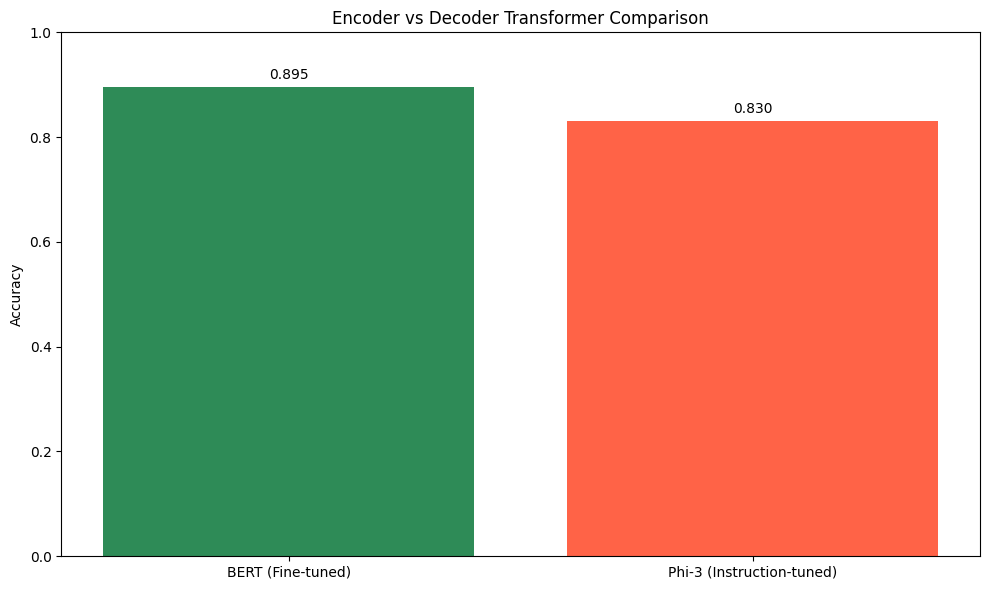

Performance Summary:
BERT (Fine-tuned): 0.8950
Phi-3 (Instruction-tuned): 0.8300

BERT Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.83      0.89       492
    Positive       0.86      0.95      0.90       508

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.89      1000


Phi-3 Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.87      0.84       526
    Positive       0.84      0.79      0.81       474

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


KEY INSIGHTS
🎯 BERT (Encoder-only):
   • Requires fine-tuning with labeled data
   • Fast inference, bidirectional attention
   • Excellent for focused classification tasks

🎯 Phi-3 (Decoder-only):
   • Wo

In [ ]:
# Evaluate BERT
bert_results = trainer.evaluate()
print("BERT Results:")
print(f"Accuracy: {bert_results['eval_accuracy']:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(test_dataset)
bert_predictions = np.argmax(predictions.predictions, axis=1)

# Get true labels from test dataset
true_labels = [test_dataset[i]['labels'].item() for i in range(len(test_dataset))]

print("\nClassification Report:")
print(classification_report(true_labels, bert_predictions,
                          target_names=['Negative', 'Positive']))



# Calculate accuracies on the exact same data
accuracies = {
    'BERT (Fine-tuned)': accuracy_score(true_labels, bert_predictions),
    'Phi-3 (Instruction-tuned)': accuracy_score(test_subset_labels, instruction_predictions)
}

# Create comparison plot
plt.figure(figsize=(10, 6))
methods = list(accuracies.keys())
scores = list(accuracies.values())

bars = plt.bar(methods, scores, color=['#2E8B57', '#FF6347'])
plt.ylabel('Accuracy')
plt.title('Encoder vs Decoder Transformer Comparison')
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Performance Summary:")
for method, accuracy in accuracies.items():
    print(f"{method}: {accuracy:.4f}")

# Show classification report for both models
print("\n" + "="*50)
print("BERT Classification Report:")
print(classification_report(true_labels, bert_predictions,
                          target_names=['Negative', 'Positive']))

print("\n" + "="*50)
print("Phi-3 Classification Report:")
print(classification_report(test_subset_labels, instruction_predictions,
                          target_names=['Negative', 'Positive']))

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("🎯 BERT (Encoder-only):")
print("   • Requires fine-tuning with labeled data")
print("   • Fast inference, bidirectional attention")
print("   • Excellent for focused classification tasks")
print()
print("🎯 Phi-3 (Decoder-only):")
print("   • Works with prompts, no fine-tuning needed")
print("   • Flexible, can handle various tasks")
print("   • Requires proper chat template formatting")
print()
print("💡 Choose based on: data availability, task requirements, and computational resources")